# Load Libaries

In [1]:
import pandas as pd
import time
from datetime import datetime

# Data Visualization
import matplotlib.pyplot as plt

# Exploring File Structure and Cleaning Data

## Train Data

The train set contains user ids and whether they have churned in March 2017. 
* is_churn = 1 means churn
* is_churn = 0 means renewal

In [2]:
train = pd.read_csv('./Data2/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Data columns (total 2 columns):
msno        992931 non-null object
is_churn    992931 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.2+ MB


In [4]:
train.describe()

,is_churn
count,992931.000000
mean,0.063923
std,0.244616
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


The train set contains churn information for 992,931 users. A majority of the users have renewed their subscription (is_churn = 0); only 6.4% have churned. 

Since it is a very biased training set, the majority group must be downsampled to ensure equal representation when creating the predictive model. We will do this now so that we will only be cleaning data needed for building the model.

In [3]:
#Split train data into churn and no churn dataframes
train_churn = train[train.is_churn == 1]
train_nochurn = train[train.is_churn == 0]

#Sample nochurn group
nochurn_sample = train_nochurn.msno.sample(n=75000, random_state=3).tolist()
train_nochurn = train[train.msno.isin(nochurn_sample)]

#Combine the two dataframes
train = pd.concat([train_churn, train_nochurn])
train.reset_index(drop=True, inplace=True)

In [4]:
train.describe()

,is_churn
count,138471.000000
mean,0.458370
std,0.498266
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [44]:
members.to_csv('members_modified.csv', index=False)

The data now has 138,471 users, but it is no longer biased with 45.8% being churned.

## Members Data

The members dataset contains user information. 
* msno
* city
* bd: age
* gender
* registered_via: registration method
* registration_init_time: format %Y%m%d

In [27]:
members = pd.read_csv('./Data/members_v3.csv')
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769473 entries, 0 to 6769472
Data columns (total 6 columns):
msno                      object
city                      int64
bd                        int64
gender                    object
registered_via            int64
registration_init_time    int64
dtypes: int64(4), object(2)
memory usage: 309.9+ MB


The dataset provides user information for 6,769,473 user which is an abundance compared to the information we have in the train dataset. We will filter down the dataset to only those in the train data.

In [19]:
members = members[members.msno.isin(train.msno.tolist())]
members.reset_index(drop=True, inplace=True)
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123815 entries, 0 to 123814
Data columns (total 6 columns):
msno                      123815 non-null object
city                      123815 non-null int64
bd                        123815 non-null int64
gender                    63206 non-null object
registered_via            123815 non-null int64
registration_init_time    123815 non-null int64
dtypes: int64(4), object(2)
memory usage: 5.7+ MB


Now we've cut down the data to 123,815. Therefore, we do not have some of the members data for all users in the train set. <br>

We are missing a lot of data for gender.

There are a few of the columns are in the wrong data type. 
* **registration_init_time** (the date the user registered on) should be a datetime object
* **city** (represented by integers) should be a categorical variable
* **gender** (Male or Female) should be a categorical variable
* **registration_via** (represented by integers) should be a categorical variable

In [20]:
members['registration_init_time'] = members.registration_init_time.apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date() if pd.notnull(x) else None)
members['city'] = members.city.astype('category')
members['gender'] = members.gender.astype('category')
members['registered_via'] = members.registered_via.astype('category')

In [21]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123815 entries, 0 to 123814
Data columns (total 6 columns):
msno                      123815 non-null object
city                      123815 non-null category
bd                        123815 non-null int64
gender                    63206 non-null category
registered_via            123815 non-null category
registration_init_time    123815 non-null object
dtypes: category(3), int64(1), object(2)
memory usage: 3.2+ MB


count    63188.000000
mean        28.764370
std          8.851143
min          1.000000
25%         22.000000
50%         27.000000
75%         33.000000
max        100.000000
Name: bd, dtype: float64


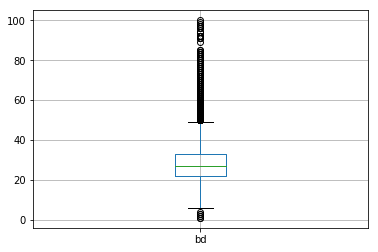

In [26]:
print(members.bd.describe())
members.boxplot(column = 'bd')
plt.show()

According to the table, the data contains members who are -48 years old while the max age is 1052. This doesn't make sense. You can also visually see that there are a lot of outliers.

To make sure these data points do not skew the data, we will cap the age range from 1 - 100 and treat 0 as missing data.

In [23]:
members['bd'] = members.bd.apply(lambda x: int(x) if x in range(1,101) else None)

In [24]:
members.describe()

,bd
count,63188.000000
mean,28.764370
std,8.851143
min,1.000000
25%,22.000000
50%,27.000000
75%,33.000000
max,100.000000


Removing those outliers cut out more than half, but it's better to only keep data that make sense.

## Transactions data

The transactions dataset describes the monetary transactions users have made on their accounts. 
* msno: user id
* payment_method_id: payment method
* payment_plan_days: length of membership plan in days
* plan_list_price: in New Taiwan Dollar (NTD)
* actual_amount_paid: in New Taiwan Dollar (NTD)
* is_auto_renew
* transaction_date: format %Y%m%d
* membership_expire_date: format %Y%m%d
* is_cancel: whether or not the user canceled the membership in this transaction

In [2]:
transactions = pd.read_csv('./Data2/transactions.csv')
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21547746 entries, 0 to 21547745
Data columns (total 9 columns):
msno                      object
payment_method_id         int64
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             int64
transaction_date          int64
membership_expire_date    int64
is_cancel                 int64
dtypes: int64(8), object(1)
memory usage: 1.4+ GB


In [35]:
len(set(transactions.msno))

2363626

Although the dataset has 21,547,745 entries, it seems that a user can make multiple transactions, meaning that the dataset contains transactional data for 2,363,626 users. However, we only need those in the train data.

In [36]:
transactions = transactions[transactions.msno.isin(train.msno.tolist())]
transactions.reset_index(drop=True, inplace=True)
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909677 entries, 0 to 1909676
Data columns (total 9 columns):
msno                      object
payment_method_id         int64
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             int64
transaction_date          int64
membership_expire_date    int64
is_cancel                 int64
dtypes: int64(8), object(1)
memory usage: 131.1+ MB


In [37]:
len(set(transactions.msno))

138471

We have at least one transaction for every user!

Again, a few columns are in the wrong data type:
* **payment_method_id** (represented by integers) should be a categorical variable
* **is_auto_renew** should be a categorical variable
* **transaction_date** should be datetime object
* **member_expire_date** should be datetime object
* **is_cancel** should be a categorical variable

In [38]:
from datetime import datetime
cat = ['payment_method_id', 'is_auto_renew', 'is_cancel']
for col in cat:
    transactions[col] = transactions[col].astype('category')

transactions['transaction_date'] = transactions['transaction_date'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date() if pd.notnull(x) else None)
transactions['membership_expire_date'] = transactions['membership_expire_date'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date() if pd.notnull(x) else None)

In [39]:
transactions.describe()

,payment_plan_days,plan_list_price,actual_amount_paid
count,1.909677e+06,1.909677e+06,1.909677e+06
mean,3.147768e+01,1.407167e+02,1.445365e+02
std,2.691498e+01,1.157037e+02,1.138081e+02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+01,9.900000e+01,9.900000e+01
50%,3.000000e+01,1.490000e+02,1.490000e+02
75%,3.000000e+01,1.490000e+02,1.490000e+02
max,4.500000e+02,2.000000e+03,2.000000e+03


There does not seem to be any missing data. However, the fact that the minimum value for all 3 columns is 0 is worth investigating into since the data might use 0 as placeholders for missing data. 

In [40]:
transactions[transactions.payment_plan_days == 0].head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
244,+PDRqxCUcwjf0pnshEarm4OLSiIwCnleg8CGDYQRSLk=,34,0,0,149,1,2015-08-31,2015-09-30,0
245,FvaiCA/DAbGupjQkBTcIXgGH7gSIX5erXWkKU6brrDo=,34,0,0,149,1,2015-08-31,2015-09-30,0
246,GjgFeNhx91KoyPHvYryrRcMhrQ3Q++LWrKD+OtEd68s=,31,0,0,149,1,2015-08-31,2015-09-30,0
249,vEi+fKPqQOfxWc5XWIXNrIWGfBlWyM2uz5kNVgALzgg=,33,0,0,149,1,2015-06-30,2015-07-31,0
255,OhSuMZNvVEA4Wx2/t7sJc08w98GZGJyE+7RNVxd9Or8=,34,0,0,149,1,2015-07-31,2015-08-31,0


In [41]:
transactions[transactions.actual_amount_paid == 0].head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
31,nttAL0YZASkTcHZH0nX7CsS1oUc5wLqMeJUqQSepslU=,35,7,0,0,0,2016-02-25,2016-03-25,0
111,lcQXwJNfBYda++AXuj9AzhWIMNyT52P2p1B1X4fRGDY=,35,7,0,0,0,2016-11-13,2016-11-20,0
114,TQBYDWyUqupf4EdTxSnO/4autGakpwxZJWNSSy25ROg=,38,7,0,0,0,2016-10-28,2017-03-19,0
350,6KrgpnP6HHn78FFbeTXG9kbR2XALAWMG1GrJSoLiHl8=,35,7,0,0,0,2015-06-07,2015-06-15,0
425,WWfFnkLCRMu6rA98VMHuQ7wAjlw4yI7wimym/tcUHw0=,35,7,0,0,0,2015-06-09,2015-06-15,0


After investigation, the 0 values seem to actually represent the value. It might just mean that the user did not choose a set plan and paying by the month. Those paying 0 NTD may be on a free trial period.

## User Log Data

The user log dataset describes listening behaviors of a user at the daily level.

* msno: user id
* date: format %Y%m%d
* num_25: # of songs played less than 25% of the song length
* num_50: # of songs played between 25% to 50% of the song length
* num_75: # of songs played between 50% to 75% of of the song length
* num_985: # of songs played between 75% to 98.5% of the song length
* num_100: # of songs played over 98.5% of the song length
* num_unq: # of unique songs played
* total_secs: total seconds played
<br>

The dataset is quite large, so it must be loaded and processed in chunks. For this project, only user logs of those in the train set is needed.

In [6]:
user_logs = pd.DataFrame()
chunksize = 100000
for chunk in pd.read_csv('./Data2/user_logs.csv', chunksize=chunksize):
    df = chunk[chunk.msno.isin(train.msno.tolist())]
    user_logs = user_logs.append(df)
user_logs.reset_index(drop=True, inplace=True)

In [7]:
user_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10927698 entries, 0 to 10927697
Data columns (total 9 columns):
msno          object
date          float64
num_25        float64
num_50        float64
num_75        float64
num_985       float64
num_100       float64
num_unq       float64
total_secs    float64
dtypes: float64(8), object(1)
memory usage: 750.3+ MB


In [15]:
len(set(user_logs.msno))

115730

There are 10,927,698 rows of data for 115,730 unique users. Unfortunately, we do not have activity logged for every user in the train set. <br>

Only the date column is in the wrong format; it should be a datetime object.

In [13]:
from datetime import datetime
user_logs['date'] = user_logs['date'].astype('int')
user_logs['date'] = user_logs['date'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date() if pd.notnull(x) else None)

In [16]:
user_logs.describe()

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,1.092770e+07,1.092770e+07,1.092770e+07,1.092770e+07,1.092770e+07,1.092770e+07,1.092770e+07
mean,6.644989e+00,1.663333e+00,1.035472e+00,1.146277e+00,3.084736e+01,3.047673e+01,-1.316696e+12
std,1.408790e+01,4.220735e+00,2.187627e+00,2.764054e+00,4.117336e+01,3.369864e+01,1.104759e+14
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-9.223372e+15
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,8.000000e+00,1.967135e+03
50%,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.700000e+01,1.900000e+01,4.713599e+03
75%,7.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,3.800000e+01,4.000000e+01,1.032347e+04
max,3.759000e+03,6.580000e+02,6.720000e+02,1.093000e+03,9.295000e+03,1.444000e+03,9.223372e+15


There are no missing values here; therefore the data cleaning is all completed!